In [406]:
!pip install pytrends
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pytrends.request import TrendReq
import time
import pandas as pd
import gtrend
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from datetime import timedelta
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

plt.style.use('seaborn-darkgrid')
matplotlib.rcParams['font.family'] = ['Heiti TC']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)

def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

# Use Pytrend Google Trends API to collect data for search term - 'data science course'



In [0]:
pytrend = TrendReq(hl='en-US')
keyword = 'data science course'
start = '2016-01-01'
end = '2020-06-10'
geo=''
cat=0
gprop=''

Acquire daily google trend data for over 9 month by concatenating multiple queries, and normalize(scaling) by the overlapping period (overlapping method)

In [0]:
overlapping = gtrend.get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)

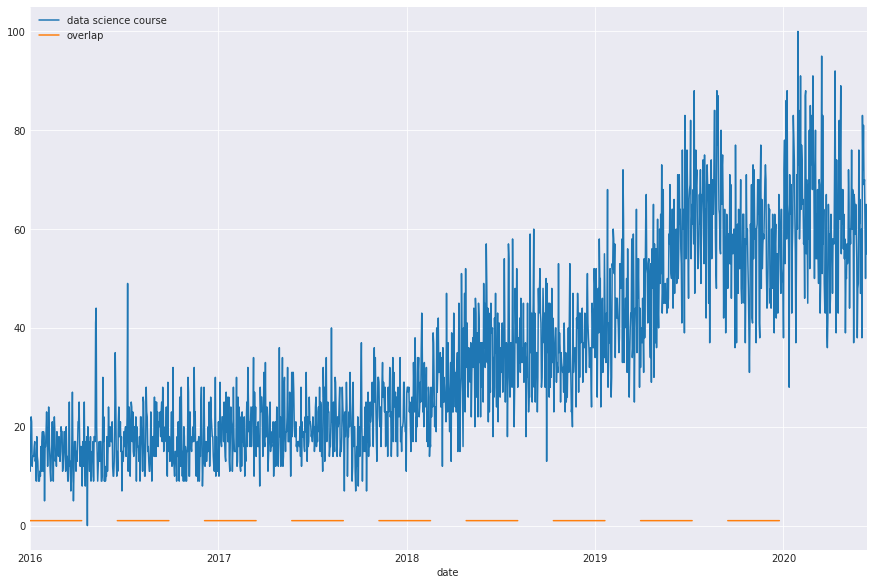

In [409]:
overlapping.plot(figsize=(15,10))

In [410]:
overlapping.head()

,data science course,overlap
date,,
2016-01-01,13.0,NaN
2016-01-02,11.0,1.0
2016-01-03,17.0,1.0
2016-01-04,22.0,1.0
2016-01-05,21.0,1.0


In [0]:
overlapping.drop('overlap', axis=1, inplace=True)

In [0]:
df = overlapping.reset_index()
df.columns = ['date', 'y']

In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1623 non-null   datetime64[ns]
 1   y       1623 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.5 KB


In [414]:
df.head(10)

,date,y
0,2016-01-01,13.0
1,2016-01-02,11.0
2,2016-01-03,17.0
3,2016-01-04,22.0
4,2016-01-05,21.0
5,2016-01-06,12.0
6,2016-01-07,14.0
7,2016-01-08,14.0
8,2016-01-09,14.0
9,2016-01-10,16.0


# Method 1 - Using Moving Average

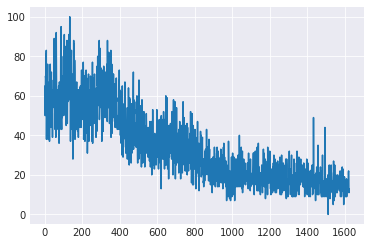

Epoch 1/20
 - 1s - loss: 0.0484
Epoch 2/20
 - 0s - loss: 0.0170
Epoch 3/20
 - 0s - loss: 0.0132
Epoch 4/20
 - 0s - loss: 0.0115
Epoch 5/20
 - 0s - loss: 0.0116
Epoch 6/20
 - 0s - loss: 0.0114
Epoch 7/20
 - 0s - loss: 0.0120
Epoch 8/20
 - 0s - loss: 0.0119
Epoch 9/20
 - 0s - loss: 0.0111
Epoch 10/20
 - 0s - loss: 0.0124
Epoch 11/20
 - 0s - loss: 0.0137
Epoch 12/20
 - 0s - loss: 0.0136
Epoch 13/20
 - 0s - loss: 0.0124
Epoch 14/20
 - 0s - loss: 0.0129
Epoch 15/20
 - 0s - loss: 0.0128
Epoch 16/20
 - 0s - loss: 0.0112
Epoch 17/20
 - 0s - loss: 0.0113
Epoch 18/20
 - 0s - loss: 0.0112
Epoch 19/20
 - 0s - loss: 0.0119
Epoch 20/20
 - 0s - loss: 0.0124
Train RMSE: 10.59
Test RMSE: 6.38


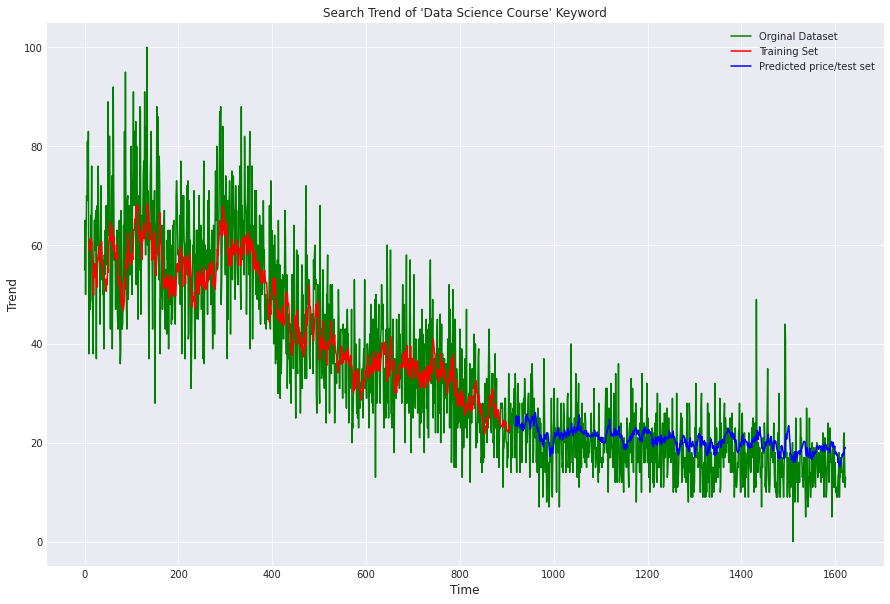

In [442]:

# Create 1D Data into Time-Series
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

# We convert Date column to datetime
df['date'] = pd.to_datetime(df['date'])
# Reindex all of dataset by Date column
df = df.reindex(index= df.index[::-1])

zaman = np.arange(1, len(df) + 1, 1)
OHCL_avg = df.mean(axis=1)
plt.plot(zaman, OHCL_avg)
plt.show()
#print(OHCL_avg.head())

# Normalize dataset
OHCL_avg = np.reshape(OHCL_avg.values, (len(OHCL_avg),1)) 
scaler = MinMaxScaler(feature_range=(0,1))
OHCL_avg = scaler.fit_transform(OHCL_avg)
#print(OHCL_avg)

#Train-Test SPLIT dataset
train_OHLC = int(len(OHCL_avg)*0.56)
test_OHLC = len(OHCL_avg) - train_OHLC
train_OHLC, test_OHLC = OHCL_avg[0:train_OHLC,:], OHCL_avg[train_OHLC:len(OHCL_avg),:]

# We create 1D dimension dataset from mean OHLV
trainX, trainY = new_dataset(train_OHLC,10)
testX, testY = new_dataset(test_OHLC,10)

# Reshape dataset for LSTM in 3D Dimension
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))
step_size = 10

# LSTM Model is created
model = Sequential()
model.add(LSTM(128, input_shape=(1, step_size), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=0.01))
model.fit(trainX, trainY, epochs=20, batch_size=60, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-Normalizing for plotting 
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Performance Measure RMSE is calculated for predicted train dataset
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Train RMSE: %.2f" % (trainScore))

# Performance Measure RMSE is calculated for predicted test dataset
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Test RMSE: %.2f" % (testScore))

# Converted predicted train dataset for plotting
trainPredictPlot = np.empty_like(OHCL_avg)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size,:] = trainPredict

# Converted predicted test dataset for plotting
testPredictPlot = np.empty_like(OHCL_avg)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHCL_avg)-1,:] = testPredict


# Finally predicted values are visualized
OHCL_avg = scaler.inverse_transform(OHCL_avg)
plt.plot(OHCL_avg, 'g', label='Orginal Dataset')
plt.plot(trainPredictPlot, 'r', label='Training Set')
plt.plot(testPredictPlot, 'b', label='Predicted price/test set')
plt.title("Search Trend of 'Data Science Course' Keyword")
plt.xlabel('Time', fontsize=12)
plt.ylabel('Trend', fontsize=12)
plt.legend(loc='upper right')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
plt.show()

## Method 2 : Using Differencing 

In [0]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    
    # differencing data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print(df.tail())
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

In [0]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    if transforms[0] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
        
    return train_predict, y_train, test_predict, y_test

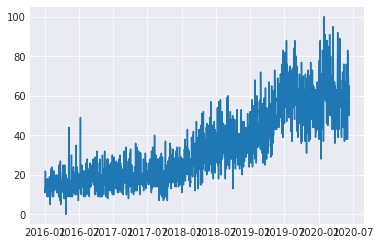

In [437]:
overlapping = overlapping.dropna()

data_science = pd.Series(overlapping.iloc[:,0])
plt.plot(data_science)

In [438]:
data_science.head()

date
2016-01-01    13.0
2016-01-02    11.0
2016-01-03    17.0
2016-01-04    22.0
2016-01-05    21.0
Freq: D, Name: data science course, dtype: float64


 -------------------------------- 
 Training Data 
 -------------------------------- 
 
                 t-0       t-1
date                          
2020-06-06  0.505618  0.359551
2020-06-07  0.393258  0.505618
2020-06-08  0.370787  0.393258
2020-06-09  0.662921  0.370787
2020-06-10  0.382022  0.662921

 -------------------------------- 
 Model Summary 
-------------------------------- 
 
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 1, 124)            62496     
_________________________________________________________________
lstm_94 (LSTM)               (None, 124)               123504    
_________________________________________________________________
dense_118 (Dense)            (None, 124)               15500     
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 

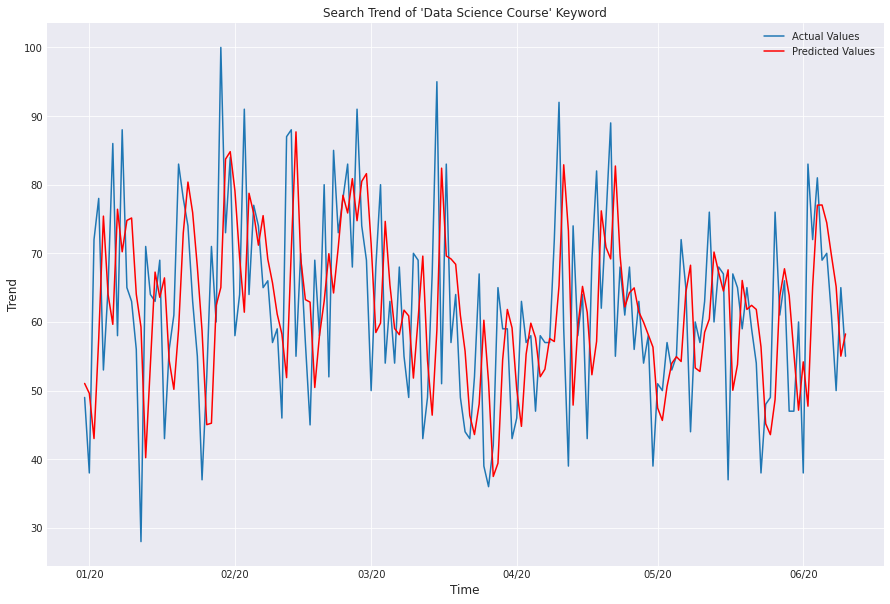

In [441]:
#preparing our training and test dataset
look_back = 10
print("\n -------------------------------- \n Training Data \n -------------------------------- \n ")
X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_science, look_back, 0.9, [True])

#building LSTM model 
model = Sequential()
model.add(LSTM(124, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(124))
model.add(Dense(124, activation='relu'))
model.add(Dense(1))
print("\n -------------------------------- \n Model Summary \n-------------------------------- \n ")
print(model.summary())

model.compile(loss='mean_squared_error', optimizer='adam')
r = model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=2)
    
# making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
    
# inverse transforming results
train_predict, y_train, test_predict, y_test = \
inverse_transforms(train_predict, y_train, test_predict, y_test, data_science, train_dates, test_dates, scaler)
    
print("\n -------------------------------- \n RMSE \n -------------------------------- \n")
error = np.sqrt(mean_squared_error(train_predict, y_train))
print('Train RMSE: %.3f' % error)
error = np.sqrt(mean_squared_error(test_predict, y_test))
print('Test RMSE: %.3f' % error)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
myFmt = mdates.DateFormatter('%m/%y')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(y_test, label='Actual Values')
plt.plot(test_predict, color='red', label='Predicted Values')
plt.title("Search Trend of 'Data Science Course' Keyword")
plt.xlabel('Time', fontsize=12)
plt.ylabel('Trend', fontsize=12)
plt.legend(loc='upper right')
plt.show()   



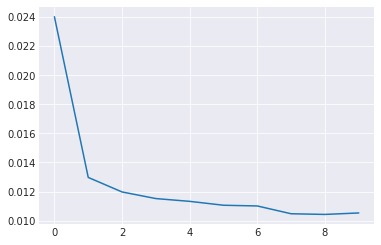

In [433]:
plt.plot(r.history['loss'])